In [1]:
# Realize ResAE 
# The decoder part only have the symmetic sturcture as the encoder, but weights and biase are initialized.
# Let's have a try.

In [2]:
# Display the result
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import utils
import Block

In [4]:
import os
import time
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers

In [5]:
tf.__version__

'1.4.0'

In [6]:
# Step1 load MNITST data
# change to mat file
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", 
                                  one_hot=True,
                                  validation_size=2000)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [7]:
x_in = tf.placeholder(tf.float32, shape=[None,28,28,1],name='inputs')
x_out = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='outputs')
code_length = 128
code = tf.placeholder(tf.float32, shape=[None,code_length],name='code')

is_training = tf.placeholder(tf.bool, name='is_training')

## Encoder part

In [8]:
# Reisudal blocks
encode_flag = True
odd_flags = None
net = x_in
blocks_en = [
    [(16, 8, 2)],
    [(32, 16, 2)],
]
for i, block in enumerate(blocks_en):
    print("index", i)
    block_params = utils.get_block(block, is_training=is_training)
    # build the net
    block_obj = Block.Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=encode_flag,
        scope = 'block'+str(i),
        summary_flag = True,
        odd_flags = odd_flags
        )
    net, odd_flags = block_obj.get_block()
    print("note odd flags : ", odd_flags)

index 0
en: False
odd_flags: False
odd_flags: [False]
block en: [False] <class 'tensorflow.python.framework.ops.Tensor'> Tensor("block0/block0/bottleneck_en0/add:0", shape=(?, 14, 14, 16), dtype=float32)
note odd flags :  [False]
index 1
en: True
odd_flags: True
odd_flags: [False, True]
block en: [False, True] <class 'tensorflow.python.framework.ops.Tensor'> Tensor("block1/block1/bottleneck_en0/add:0", shape=(?, 7, 7, 32), dtype=float32)
note odd flags :  [False, True]


In [9]:
# get shape of last block
encode_last_block_shape = net.get_shape()

In [10]:
# flatten layer
with tf.name_scope('flatten_en'):
    net = layers.flatten(net)
    tf.summary.histogram('flatten_en',net)
flatten_length = int(net.get_shape()[-1])

## Encoder layer

In [11]:
with tf.name_scope('encoder_layer'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=code_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('encode_layer',net)
    code = net

## Decoder block

In [12]:
encode_last_block_shape[2]
print(odd_flags)

[False, True]


In [13]:
with tf.name_scope('flatten_de'):
    net = layers.fully_connected(
        inputs = net,
        num_outputs=flatten_length,
        activation_fn=tf.nn.relu,
        )
    tf.summary.histogram('flatten_en', net)

In [14]:
# flatten to convolve
with tf.name_scope('flatten_to_conv'):
    net = tf.reshape(
        net, 
        [-1, int(encode_last_block_shape[1]), 
         int(encode_last_block_shape[2]), int(encode_last_block_shape[3])])

In [15]:
net.get_shape()

TensorShape([Dimension(None), Dimension(7), Dimension(7), Dimension(32)])

In [16]:
# Residual blocks
blocks_de = [
     [(16, 16, 2)],
     [(1, 8, 2)],]
for i, block in enumerate(blocks_de):
    block_params = utils.get_block(block, is_training=is_training)
    # build the net
    
    block_obj = Block.Block(
        inputs = net,
        block_params = block_params,
        is_training = is_training,
        encode_flag=False,
        scope = 'block'+str(i),
        summary_flag = True,
        odd_flags = odd_flags
    )
    net = block_obj.get_block()
x_out = net

0   (?, 7, 7, 16)
1   (?, 14, 14, 16)
2   (?, 14, 14, 16)
(?, 14, 14, 16)
block de: <class 'tensorflow.python.framework.ops.Tensor'> Tensor("block0_1/add:0", shape=(?, 14, 14, 16), dtype=float32)
0   (?, 14, 14, 8)
1   (?, 28, 28, 8)
2   (?, 28, 28, 1)
(?, 28, 28, 1)
block de: <class 'tensorflow.python.framework.ops.Tensor'> Tensor("block1_1/add:0", shape=(?, 28, 28, 1), dtype=float32)


In [17]:
# loss function
with tf.name_scope('loss'):
    cost = tf.reduce_mean(tf.square(x_out-x_in))
    tf.summary.scalar('loss', cost)

In [18]:
# learning rate
with tf.name_scope('learning_rate'):
    init_lr = tf.placeholder(tf.float32, name='LR')
    global_step = tf.placeholder(tf.float32, name="global_step")
    decay_step = tf.placeholder(tf.float32, name="decay_step")
    decay_rate = tf.placeholder(tf.float32, name="decay_rate")
    learning_rate = tf.train.exponential_decay(
        learning_rate = init_lr ,
        global_step = global_step,
        decay_steps = decay_step,
        decay_rate = decay_rate,
        staircase=False,
        name=None)   

In [19]:
def feed_dict(train,batchsize=100,drop=0.5, lr_dict=None):
    """Make a TensorFlow feed_dict: maps data onto Tensor placeholders."""
    if train:
        xs, _ = mnist.train.next_batch(batchsize)
        f_dict = {x_in: xs.reshape([-1,28,28,1]), 
                  is_training: True}
        f_dict.update(lr_dict)
    else:    
        # validation
        x_val,_ = mnist.validation.images,mnist.validation.labels
        f_dict = {x_in: x_val.reshape([-1,28,28,1]),
                  is_training: False}
    return f_dict

In [20]:
# Train step 
# note: should add update_ops to the train graph
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cost) 

In [21]:
# Merge all the summaries and write to logdir
logdir = './log'
if not os.path.exists(logdir):
    os.mkdir(logdir)
merged = tf.summary.merge_all()
# Initialize the variables
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_writer = tf.summary.FileWriter(logdir + '/train',
                                      sess.graph)
val_writer = tf.summary.FileWriter(logdir + '/validation',
                                   sess.graph)

In [22]:
# Training the model by repeatedly running train_step
import time 
epochs = 100
batchsize= 100
num_batches = mnist.train.images.shape[0] // batchsize
# num_batches = 200

lr_init = 0.001
d_rate = 0.9

x_epoch = np.arange(0,epochs,1)
y_loss_trn = np.zeros(x_epoch.shape)
y_loss_val = np.zeros(x_epoch.shape)

# Init all variables
timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
print("[%s]: Epochs    Trn_loss    Val_loss" % (timestamp))
for i in range(epochs):
    lr_dict = {init_lr: lr_init, global_step:i,
               decay_step: i, decay_step: batchsize,
               decay_rate: d_rate}
    loss_trn_all = 0.0
    for b in range(num_batches):
        train_dict = feed_dict(True,lr_dict=lr_dict)
        # train
        summary_trn, _, loss_trn = sess.run(
            [merged, train_step, cost], 
            feed_dict=train_dict)
        loss_trn_all += loss_trn
    
    y_loss_trn[i] = loss_trn_all / num_batches
    train_writer.add_summary(summary_trn, i)
    # validation
    val_dict = feed_dict(False)
    summary_val, y_loss_val[i] = sess.run(
        [merged, cost],feed_dict=val_dict)
    val_writer.add_summary(summary_val, i)
    if i % 10 == 0:
        timestamp = time.strftime('%Y-%m-%d: %H:%M:%S', time.localtime(time.time()))
        print('[%s]: %d    %.4f    %.4f' % (timestamp, i, 
                                            y_loss_trn[i], y_loss_val[i]))

[2019-02-27: 17:18:12]: Epochs    Trn_loss    Val_loss
[2019-02-27: 17:18:26]: 0    0.0172    0.0055
[2019-02-27: 17:20:41]: 10    0.0018    0.0018
[2019-02-27: 17:22:54]: 20    0.0014    0.0014
[2019-02-27: 17:25:05]: 30    0.0012    0.0013
[2019-02-27: 17:27:17]: 40    0.0011    0.0012
[2019-02-27: 17:29:31]: 50    0.0011    0.0011
[2019-02-27: 17:31:43]: 60    0.0010    0.0011
[2019-02-27: 17:33:58]: 70    0.0010    0.0010
[2019-02-27: 17:36:11]: 80    0.0009    0.0010
[2019-02-27: 17:38:25]: 90    0.0009    0.0010


Text(0,0.5,'Loss')

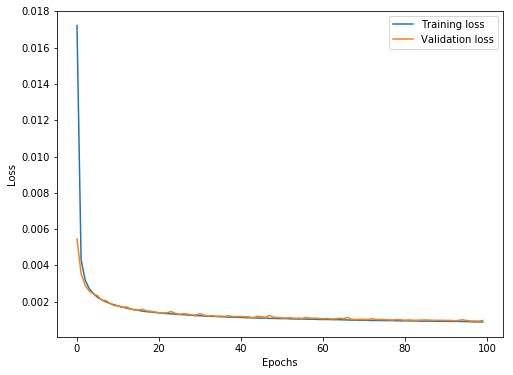

In [23]:
plt.rcParams["figure.figsize"] = [8.0,6.0]

plt.plot(x_epoch, y_loss_trn)
plt.plot(x_epoch, y_loss_val)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [24]:
import pickle
data_dict = {
    "x_epoch": x_epoch,
    "y_loss_trn": y_loss_trn,
    "y_loss_val": y_loss_val,
}
with open("./result_resae13.pkl", 'wb') as fp:
    pickle.dump(data_dict, fp)

In [25]:
# test a image
img, _ = mnist.validation.next_batch(10)
img = img.reshape(-1,28,28,1)

In [26]:
img_est = sess.run(x_out, feed_dict={x_in: img, is_training: False})

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


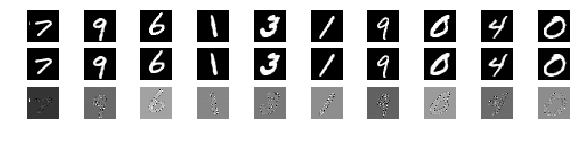

In [27]:
def gen_norm(img):
    return (img-img.min())/(img.max() - img.min())

n_examples = 10
fig, axs = plt.subplots(3, n_examples, figsize=(10, 2))
for example_i in range(n_examples):
    # raw
    axs[0][example_i].imshow(np.reshape(img[example_i, :], (28, 28)), cmap='gray')
    axs[0][example_i].axis('off')
    # learned
    axs[1][example_i].imshow(np.reshape(img_est[example_i, :], (28, 28)), cmap='gray')
    axs[1][example_i].axis('off')
    # residual
    norm_raw = gen_norm(np.reshape(img[example_i, :], (28, 28)))
    norm_est = gen_norm(np.reshape(img_est[example_i, :],(28, 28)))
    axs[2][example_i].imshow(norm_raw - norm_est, cmap='gray')
    axs[2][example_i].axis('off')

fig.show()
plt.draw()